In [ ]:
import os
from pprint import pprint
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label
import ttach as tta

sys.path.append("../")

from monkey.config import TrainingIOConfig
from monkey.data.dataset import get_detection_dataloaders
from monkey.model.efficientunetb0.architecture import (
    get_multihead_efficientunet,
)
from monkey.model.hovernext.model import get_custom_hovernext
from monkey.model.utils import get_activation_function
from tqdm.autonotebook import tqdm
from monkey.model.utils import (
    get_multiclass_patch_F1_score_batch,
    get_patch_F1_score_batch,
)
from monkey.data.data_utils import (
    imagenet_denormalise,
    dilate_mask,
    morphological_post_processing,
)
from monkey.model.hovernext.model import (
    get_convnext_unet,
    get_custom_hovernext,
)

run_config = {
    "val_fold": 3,  # [1-5]
    "batch_size": 16,
    "optimizer": "AdamW",
    "learning_rate": 0.0004,
    "weight_decay": 0.01,
    "epochs": 50,
    "loss_function": {
        "head_1": "BCE_Dice",
        "head_2": "BCE_Dice",
        "head_3": "BCE_Dice",
    },
    "loss_pos_weight": 1.0,
    "do_augmentation": True,
    "activation_function": {
        "head_1": "sigmoid",
        "head_2": "sigmoid",
        "head_3": "sigmoid",
    },
    "use_nuclick_masks": False,  # Whether to use NuClick segmentation masks,
    "include_background_channel": False,
}

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/patches_256",
)
IOconfig.set_mask_dir(
    "/home/u1910100/Documents/Monkey/patches_256/annotations/nuclick_masks_processed"
)

models = []
folds = [3]
for i in folds:
    checkpoint_path = f"/home/u1910100/Documents/Monkey/runs/cell_multiclass_det/convnextv2_tiny_pannuke_seg/fold_{i}/epoch_75.pth"
    # model = get_multihead_efficientunet(
    #     out_channels=[2, 1, 1], pretrained=False
    # )
    model = get_custom_hovernext(
        enc="convnextv2_tiny.fcmae_ft_in22k_in1k",
        pretrained=False,
        decoders_out_channels=[2,1,1],
        use_batchnorm=True,
        attention_type="scse",
    )
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    print(checkpoint["epoch"])
    model.load_state_dict(checkpoint["model"])
    model.eval()
    model.to("cuda")
    models.append(model)


train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="segmentation",
    batch_size=run_config["batch_size"],
    do_augmentation=run_config["do_augmentation"],
)


activation_dict = {
    "head_1": get_activation_function(
        run_config["activation_function"]["head_1"]
    ),
    "head_2": get_activation_function(
        run_config["activation_function"]["head_2"]
    ),
    "head_3": get_activation_function(
        run_config["activation_function"]["head_3"]
    ),
}

In [2]:
def multihead_unet_post_process(
    inflamm_probs: torch.Tensor,
    lymph_probs: torch.Tensor,
    mono_probs: torch.Tensor,
    contour_probs: torch.Tensor,
    thresholds: list = [0.5, 0.5, 0.5, 0.3],
) -> dict[str, np.ndarray]:
    """
    Args:
        Thresholds: [overall, lymph, mono, contour]
    """
    contour_pred_binary = (
        (contour_probs > thresholds[3]).float().numpy(force=True)
    )

    overall_pred_binary = (
        (inflamm_probs > thresholds[0]).float().numpy(force=True)
    )
    lymph_pred_binary = (
        (lymph_probs > thresholds[1]).float().numpy(force=True)
    )
    mono_pred_binary = (
        (mono_probs > thresholds[2]).float().numpy(force=True)
    )

    overall_pred_binary[contour_pred_binary > 0] = 0
    lymph_pred_binary[contour_pred_binary > 0] = 0
    mono_pred_binary[contour_pred_binary > 0] = 0

    # Post processing
    overall_pred_binary = morphological_post_processing(
        overall_pred_binary
    )
    lymph_pred_binary = morphological_post_processing(
        lymph_pred_binary
    )
    mono_pred_binary = morphological_post_processing(mono_pred_binary)

    processed_masks = {
        "inflamm_mask": overall_pred_binary[:, 0, :, :],
        "contour_mask": contour_pred_binary[:, 0, :, :],
        "lymph_mask": lymph_pred_binary[:, 0, :, :],
        "mono_mask": mono_pred_binary[:, 0, :, :],
    }
    return processed_masks

negative pixels: 739707312
lymph pixels: 13923328
mono pixels: 10846800
train patches: 11665
test patches: 2650


validation:   0%|          | 0/2650 [00:00<?, ?it/s]|2025-01-07|16:50:25.053| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


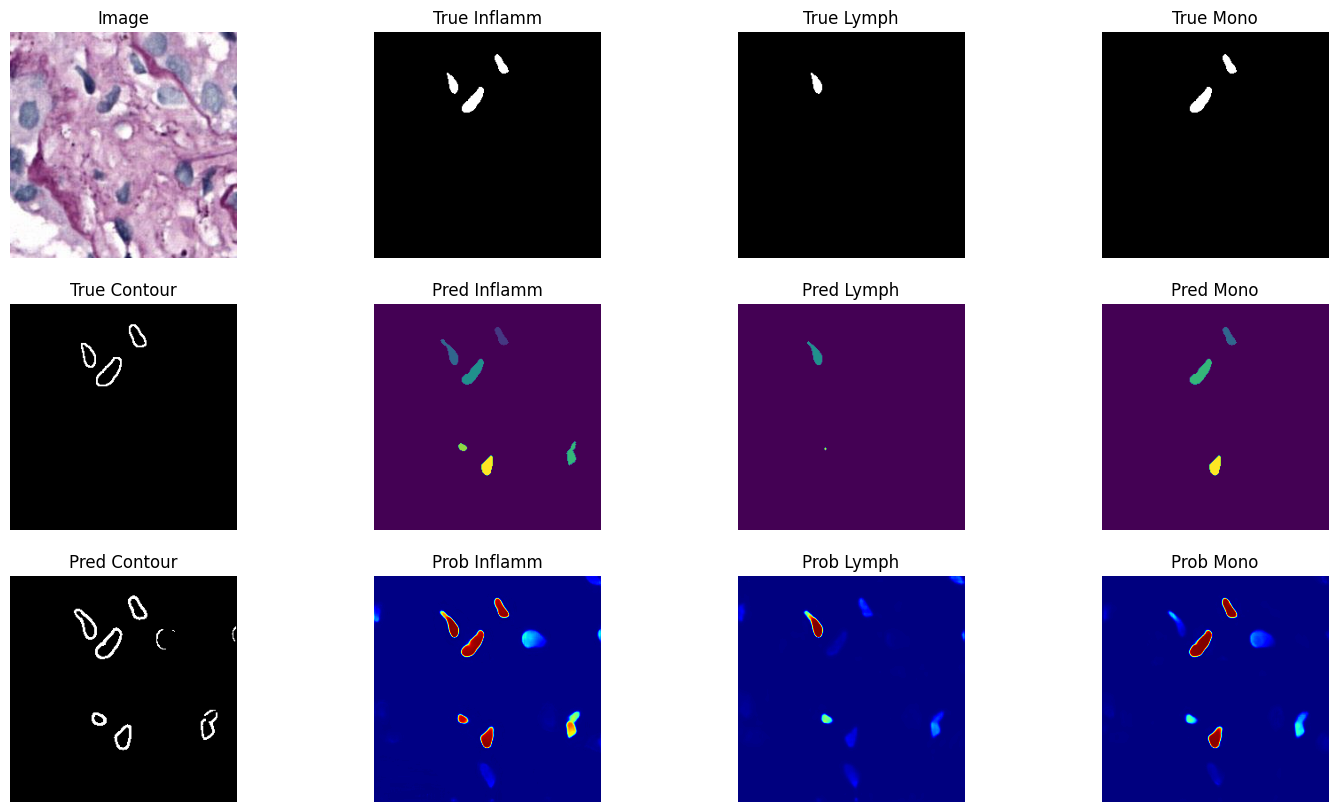

validation:   0%|          | 1/2650 [00:00<13:29,  3.27it/s]|2025-01-07|16:50:25.357| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


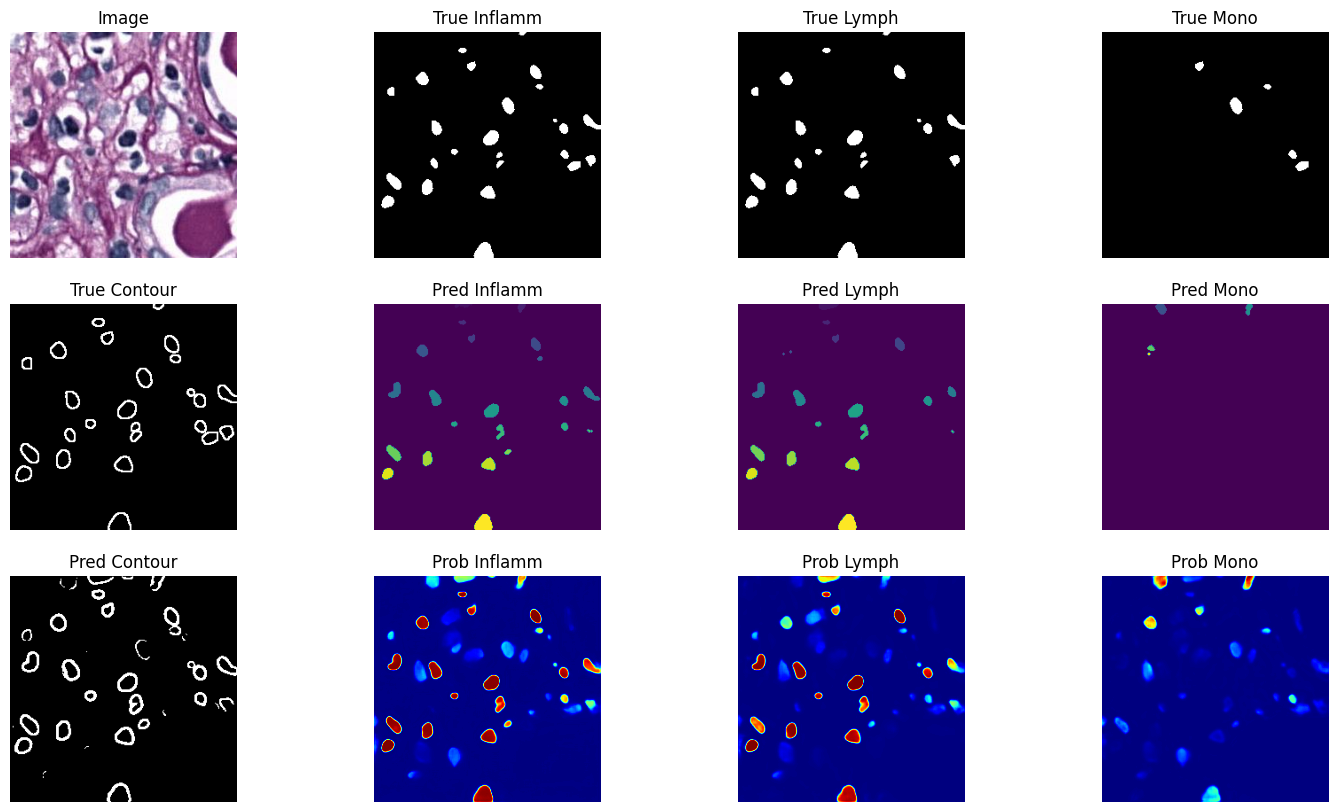

validation:   0%|          | 2/2650 [00:00<13:40,  3.23it/s]|2025-01-07|16:50:25.662| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


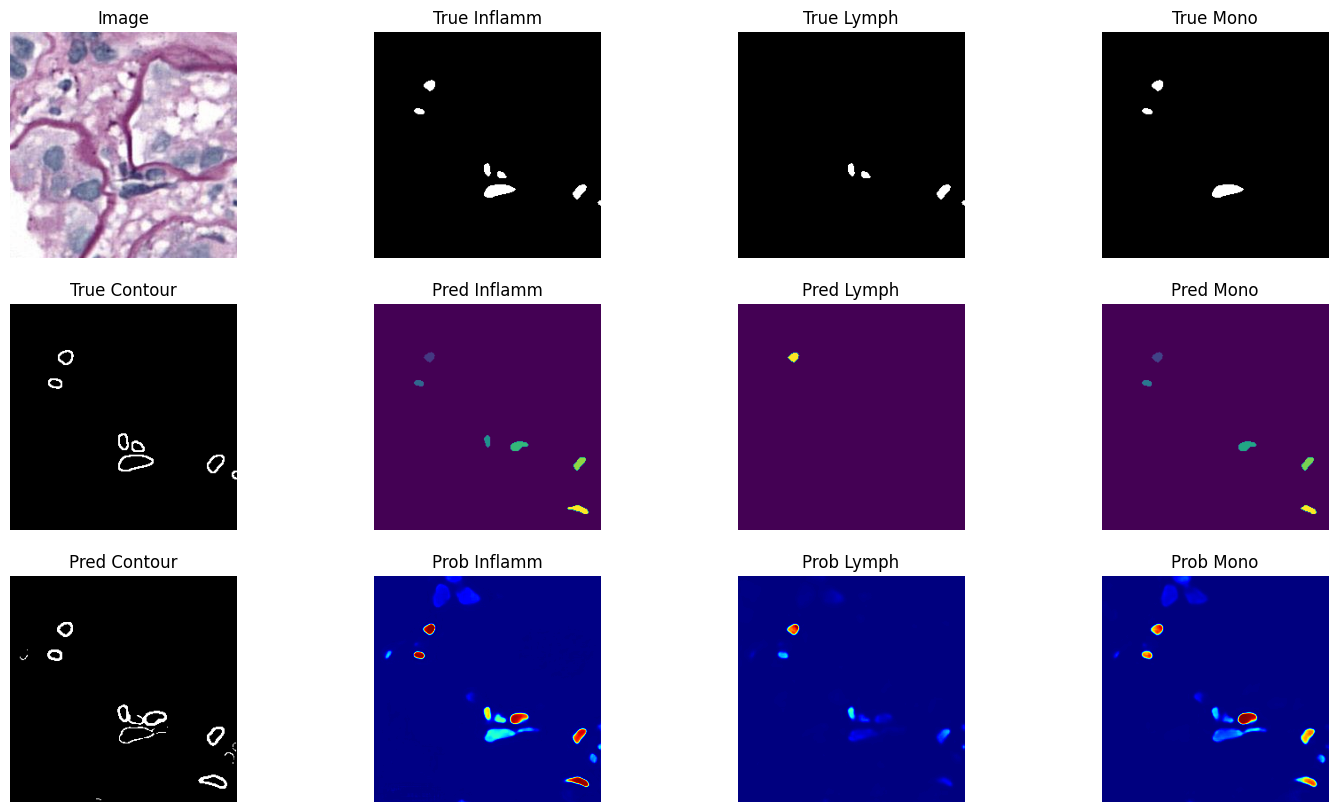

validation:   0%|          | 3/2650 [00:00<13:23,  3.30it/s]|2025-01-07|16:50:25.957| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


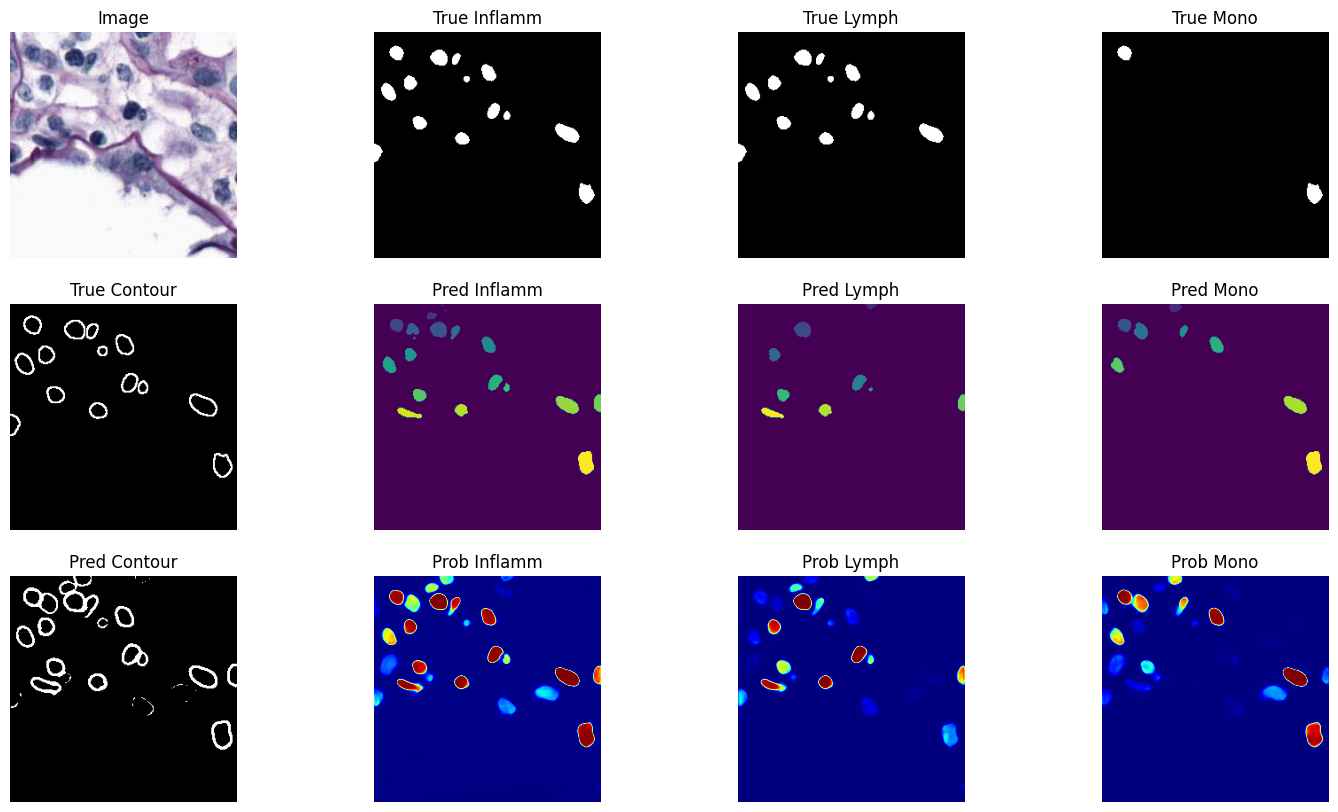

validation:   0%|          | 4/2650 [00:01<13:12,  3.34it/s]|2025-01-07|16:50:26.254| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


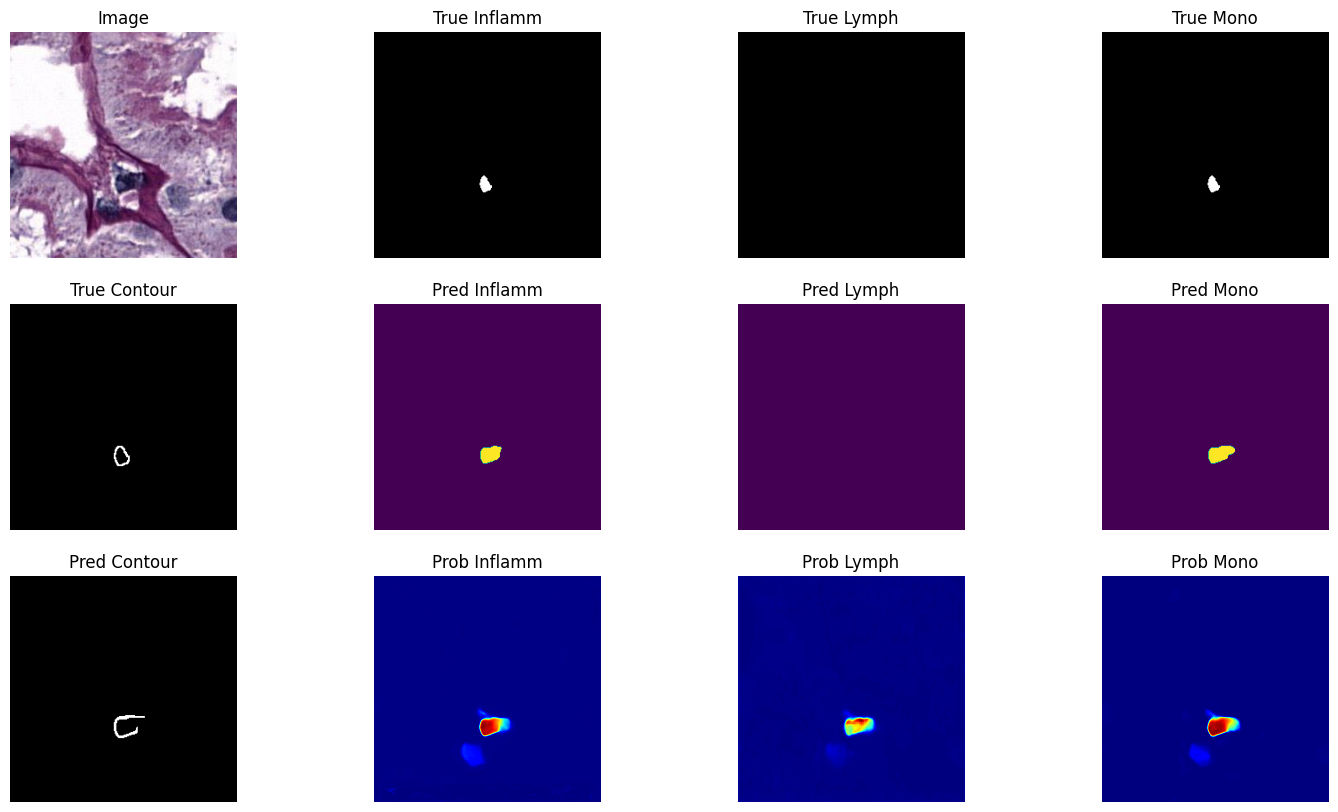

validation:   0%|          | 5/2650 [00:01<13:09,  3.35it/s]|2025-01-07|16:50:26.553| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


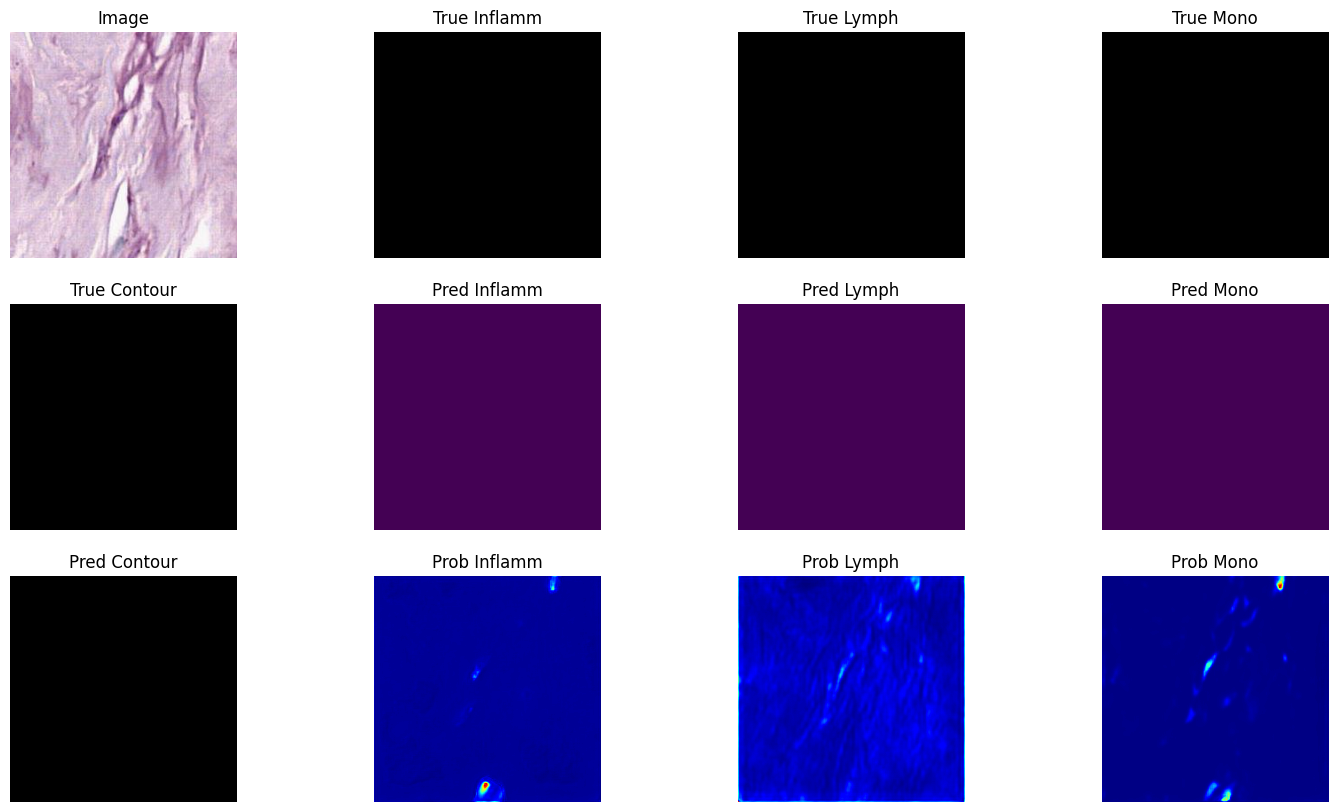

validation:   0%|          | 6/2650 [00:01<15:51,  2.78it/s]|2025-01-07|16:50:27.029| [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


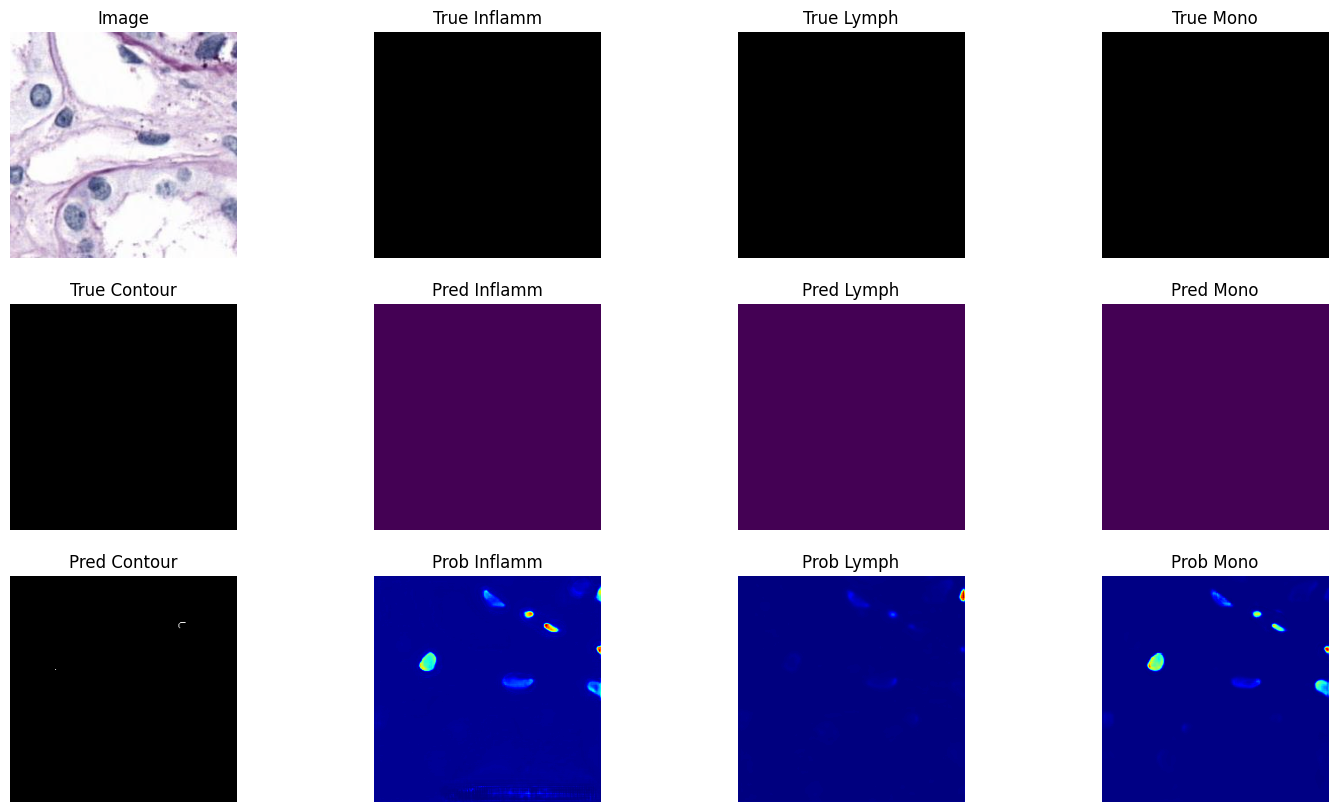

In [5]:
train_loader, val_loader = get_detection_dataloaders(
    IOconfig,
    val_fold=run_config["val_fold"],
    dataset_name="segmentation",
    batch_size=1,
    do_augmentation=run_config["do_augmentation"],
)

for i, data in enumerate(
    tqdm(val_loader, desc="validation", leave=False)
):

    fig, axes = plt.subplots(3, 4, figsize=(18, 10))

    images = data["image"].float().to("cuda")
    inflamm_true_masks = (
        data["binary_mask"][:, 0, :, :].float().numpy(force=True)
    )
    lymph_true_masks = (
        data["class_mask"][:, 0, :, :].float().numpy(force=True)
    )
    mono_true_masks = (
        data["class_mask"][:, 1, :, :].float().numpy(force=True)
    )
    contour_true_masks = (
        data["contour_mask"][:, 0, :, :].float().numpy(force=True)
    )

    with torch.no_grad():
        inflamm_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        lymph_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        mono_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        contour_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        for model in models:
            logits_pred = model(images)
            head_1_logits = logits_pred[:, 0:1, :, :]
            head_2_logits = logits_pred[:, 2:3, :, :]
            head_3_logits = logits_pred[:, 3:4, :, :]
            contour_logits = logits_pred[:, 1:2, :, :]

            _inflamm_prob = activation_dict["head_1"](head_1_logits)
            _lymph_prob = activation_dict["head_2"](head_2_logits)
            _mono_prob = activation_dict["head_3"](head_3_logits)
            _contour_prob = activation_dict["head_1"](contour_logits)

            inflamm_prob += _inflamm_prob.detach().cpu()
            lymph_prob += _lymph_prob.detach().cpu()
            mono_prob += _mono_prob.detach().cpu()
            contour_prob += _contour_prob.detach().cpu()

        inflamm_prob /= len(models)
        lymph_prob /= len(models)
        mono_prob /= len(models)

    processed_output = multihead_unet_post_process(
        inflamm_prob,
        lymph_prob,
        mono_prob,
        contour_probs=contour_prob,
        thresholds=[0.5, 0.5, 0.5, 0.3],
    )

    inflamm_mask = label(processed_output["inflamm_mask"][0])
    lymph_mask = label(processed_output["lymph_mask"][0])
    mono_mask = label(processed_output["mono_mask"][0])

    images = images.numpy(force=True)[0]
    images = np.moveaxis(images, 0, 2)
    images = imagenet_denormalise(images)

    axes[0][0].imshow(images)
    axes[0][0].set_title("Image")

    axes[0][1].imshow(inflamm_true_masks[0], cmap="gray")
    axes[0][1].set_title("True Inflamm")

    axes[2][0].imshow(
        processed_output["contour_mask"][0], cmap="gray"
    )
    axes[2][0].set_title("Pred Contour")

    axes[2][1].imshow(inflamm_prob[0][0], cmap="jet")
    axes[2][1].set_title(f"Prob Inflamm")

    axes[0][2].imshow(lymph_true_masks[0], cmap="gray")
    axes[0][2].set_title("True Lymph")

    axes[0][3].imshow(mono_true_masks[0], cmap="gray")
    axes[0][3].set_title("True Mono")

    axes[2][3].imshow(mono_prob[0][0], cmap="jet")
    axes[2][3].set_title(f"Prob Mono")

    axes[1][0].imshow(contour_true_masks[0], cmap="gray")
    axes[1][0].set_title("True Contour")

    axes[1][2].imshow(
        lymph_mask,
    )
    axes[1][2].set_title("Pred Lymph")

    axes[1][3].imshow(mono_mask)
    axes[1][3].set_title("Pred Mono")

    axes[1][1].imshow(
        inflamm_mask,
    )
    axes[1][1].set_title("Pred Inflamm")

    axes[2][2].imshow(lymph_prob[0][0], cmap="jet")
    axes[2][2].set_title(f"Prob Lymph")

    for ax in axes.ravel():
        ax.axis("off")
    plt.show()

    if i > 5:
        break

Evaluation

In [ ]:
running_inflamm_f1 = 0.0
running_inflamm_precision = 0.0
running_inflamm_recall = 0.0
running_lymph_f1 = 0.0
running_lymph_precision = 0.0
running_lymph_recall = 0.0
running_mono_f1 = 0.0
running_mono_precision = 0.0
running_mono_recall = 0.0

for i, data in enumerate(
    tqdm(val_loader, desc="validation", leave=False)
):
    images = data["image"].float().to("cuda")
    inflamm_true_masks = (
        data["binary_mask"][:, 0, :, :].float().numpy(force=True)
    )
    lymph_true_masks = (
        data["class_mask"][:, 0, :, :].float().numpy(force=True)
    )
    mono_true_masks = (
        data["class_mask"][:, 1, :, :].float().numpy(force=True)
    )

    with torch.no_grad():
        inflamm_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        lymph_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        mono_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        contour_prob = torch.zeros(
            size=(images.shape[0], 1, 256, 256), device="cpu"
        )
        for model in models:
            logits_pred = model(images)
            head_1_logits = logits_pred[:, 0:1, :, :]
            head_2_logits = logits_pred[:, 2:3, :, :]
            head_3_logits = logits_pred[:, 3:4, :, :]
            contour_logits = logits_pred[:, 1:2, :, :]

            _inflamm_prob = activation_dict["head_1"](head_1_logits)
            _lymph_prob = activation_dict["head_2"](head_2_logits)
            _mono_prob = activation_dict["head_3"](head_3_logits)
            _contour_prob = activation_dict["head_1"](contour_logits)

            inflamm_prob += _inflamm_prob.detach().cpu()
            lymph_prob += _lymph_prob.detach().cpu()
            mono_prob += _mono_prob.detach().cpu()
            contour_prob += _contour_prob.detach().cpu()

        inflamm_prob /= len(models)
        lymph_prob /= len(models)
        mono_prob /= len(models)
        contour_prob /= len(models)

        processed_output = multihead_unet_post_process(
            inflamm_prob,
            lymph_prob,
            mono_prob,
            contour_probs=contour_prob,
            thresholds=[0.5, 0.5, 0.5, 0.3],
        )

    # Compute detection F1 score
    inflamm_metrics = get_patch_F1_score_batch(
        processed_output["inflamm_mask"],
        inflamm_true_masks,
        5,
        inflamm_prob[:, 0, :, :],
    )
    lymph_metrics = get_patch_F1_score_batch(
        processed_output["lymph_mask"],
        lymph_true_masks,
        4,
        lymph_prob[:, 0, :, :],
    )
    mono_metrics = get_patch_F1_score_batch(
        processed_output["mono_mask"],
        mono_true_masks,
        5,
        mono_prob[:, 0, :, :],
    )

    running_inflamm_f1 += (inflamm_metrics["F1"]) * images.size(0)
    running_inflamm_precision += (
        inflamm_metrics["Precision"]
    ) * images.size(0)
    running_inflamm_recall += (
        inflamm_metrics["Recall"]
    ) * images.size(0)
    running_lymph_f1 += (lymph_metrics["F1"]) * images.size(0)
    running_lymph_precision += (
        lymph_metrics["Precision"]
    ) * images.size(0)
    running_lymph_recall += (lymph_metrics["Recall"]) * images.size(0)
    running_mono_f1 += (mono_metrics["F1"]) * images.size(0)
    running_mono_precision += (
        mono_metrics["Precision"]
    ) * images.size(0)
    running_mono_recall += (mono_metrics["Recall"]) * images.size(0)

results = {
    "inflamm_F1": running_inflamm_f1 / len(val_loader.sampler),
    "lymph_F1": running_lymph_f1 / len(val_loader.sampler),
    "mono_F1": running_mono_f1 / len(val_loader.sampler),
    "inflamm_precision": running_inflamm_precision
    / len(val_loader.sampler),
    "lymph_precision": running_lymph_precision
    / len(val_loader.sampler),
    "mono_precision": running_mono_precision
    / len(val_loader.sampler),
    "inflamm_recall": running_inflamm_recall
    / len(val_loader.sampler),
    "lymph_recall": running_lymph_recall / len(val_loader.sampler),
    "mono_recall": running_mono_recall / len(val_loader.sampler),
}

pprint(results)